In [1]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib
import pandas as pd
import os
from itertools import product
from argparse import Namespace
from order_execution import compute_objective
from table_utils import *

# Varying risk parameters

In [2]:
gradient_types_str = {"complete": "Complete policy gradient", "naive": "Naive policy gradient", "ppo": "PPO"}
objectives_str = {"cost": "Cost", "forsyth": "2nd moment", "exponential": "Exponential"}
objectives_list = list(objectives_str.keys())
baselines_str = {"twap": "TWAP", "all_trading": "Trading all", "no_trading": "No trading"}
cost_type = ("linear", "forsyth")
param_keys = ("gamma", "lambda")
method_keys = ("complete", "naive")

directory_str = "results/execution/"
twap_endvals = {}
twap_results = {}

for key in cost_type: 
    directory = os.fsencode(directory_str)
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".pkl") and filename.startswith("twap"):
            result = pickle.load( open( directory_str + filename, "rb" ) )
            args = Namespace(**result)
            twap_endvals[args.cost_type] = result["endvals"]
            twap_results[args.cost_type] = result

directories_str = {k: directory_str + "execution_{}/".format(k) for k in param_keys}
vals = {k1: {k2: {k3: [] for k3 in method_keys} for k2 in cost_type} for k1 in param_keys}
twap_vals = {k1: {k2: {k3: [] for k3 in method_keys} for k2 in cost_type} for k1 in param_keys}
param_vals = {k1: {k2: {k3: [] for k3 in method_keys} for k2 in cost_type} for k1 in param_keys}
results = {k1: {k2: {k3: [] for k3 in method_keys} for k2 in cost_type} for k1 in param_keys}

for key in param_keys: 
    directory = os.fsencode(directories_str[key])
    i = 0
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".pkl"):
            result = pickle.load( open( directories_str[key] + filename, "rb" ) )
            args = Namespace(**result)
            vals[key][args.cost_type][args.gradient_type].append(torch.mean(compute_objective(result["endvals"], args), axis=-1).detach().numpy())
            twap_vals[key][args.cost_type][args.gradient_type].append(torch.mean(compute_objective(twap_endvals[args.cost_type], args), axis=-1).detach().numpy())
            param_vals[key][args.cost_type][args.gradient_type].append(args.gamma if key == "gamma" else args.exp_param)
            results[key][args.cost_type][args.gradient_type].append(result)
            i += 1
            print(i)

param_order = {k1: {k2: {k3: [] for k3 in method_keys} for k2 in cost_type} for k1 in param_keys}
for k1 in param_keys:
    for k2 in cost_type:
        for k3 in method_keys:
            param_vals[k1][k2][k3] = np.array(param_vals[k1][k2][k3])
            param_order[k1][k2][k3] = np.argsort(param_vals[k1][k2][k3])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


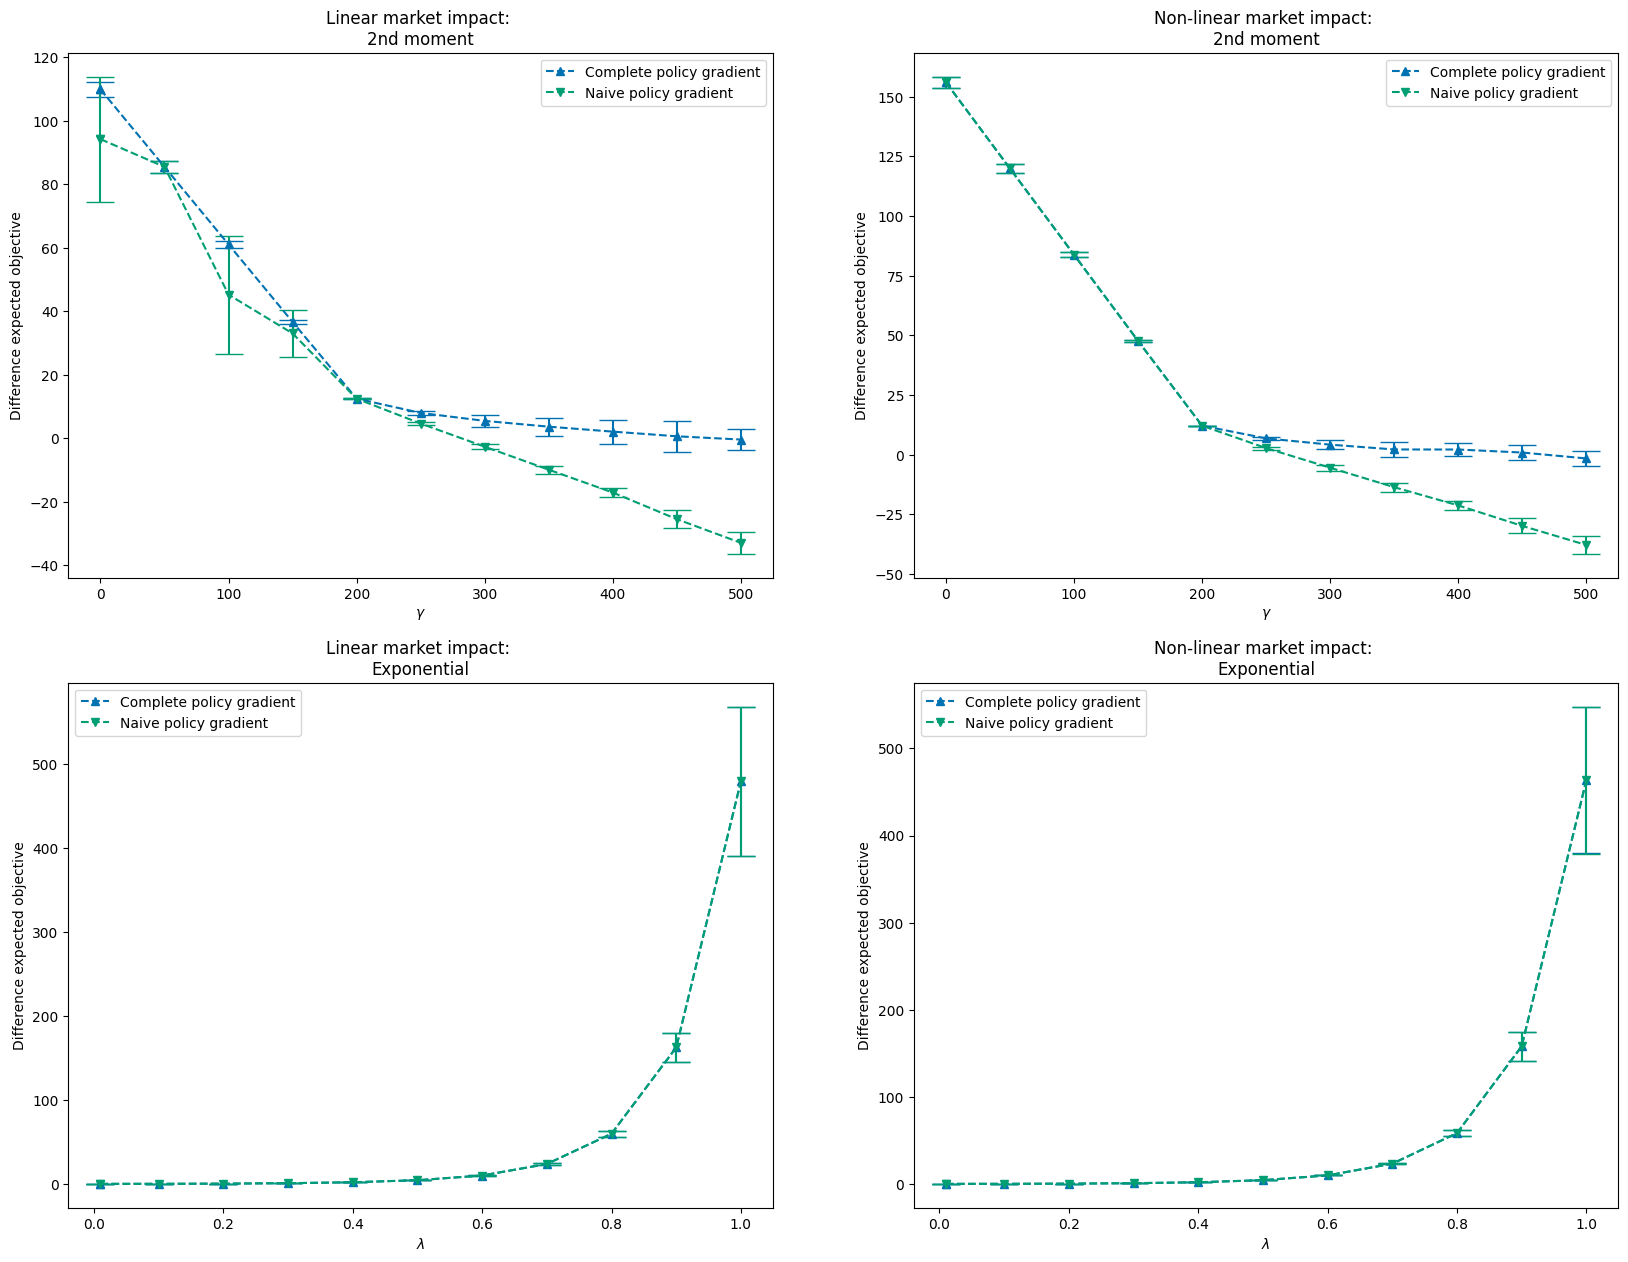

In [3]:
plt.style.use('seaborn-colorblind')
markers = ("^--", "v--", "o--", "s--")
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(2, 2, figsize=(20,15))
titles = ("Linear market impact", "Non-linear market impact")
objectives_names = {"lambda": "Exponential", "gamma": "2nd moment"}

for i in range(2):
    k1 = param_keys[i]
    for ii in range(2):
        k2 = cost_type[ii]
        ax = axs[i, ii] 
        col_idx = 0
        for j in range(2):
            k3 = method_keys[j]
            name = gradient_types_str[k3]
            ys =  np.stack(twap_vals[k1][k2][k3], axis=-1) - np.stack(vals[k1][k2][k3], axis=-1)
            xs = param_vals[k1][k2][k3][param_order[k1][k2][k3]]
            std_values = np.std(ys, axis=0)
            mean_values = np.mean(ys, axis=0)
            ax.errorbar(xs, mean_values[param_order[k1][k2][k3]], yerr=std_values[param_order[k1][k2][k3]], capsize=10, fmt=markers[col_idx], markersize=6)
            ax.plot((xs[0],),(mean_values[param_order[k1][k2][k3][0]],), markers[col_idx], label=name, color=cols[col_idx], markersize=6)
            col_idx += 1

        ax.legend()
        ax.set_title(titles[ii] + ": \n" + objectives_names[k1])
        ax.set_xlabel("$\{}$".format(k1))
        ax.set_ylabel("Difference expected objective")
        

tikzplotlib.save('results/order_execution_risk_aversion_diff.tex', figure=fig, encoding='utf-8')
#plt.savefig('results/execution_risk_aversion_diff.png')
plt.show()

# Comparing methods

In [4]:
results = []
filenames = []
directory = os.fsencode("results/execution")
    
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".pkl"):
        filenames.append(filename)
        results.append(pickle.load( open( "results/execution/" + filename, "rb" ) ))

num_runs = results[0]["num_runs"] 
gradient_types = {"complete": "Complete policy gradient", "naive": "Naive policy gradient", "ppo": "PPO"}
objectives = {"cost": "Cost", "forsyth_high": "2nd moment, high risk aversion", "forsyth_low": "2nd moment, low risk aversion", "exponential_high": "Exponential, high risk aversion", "exponential_low": "Exponential, low risk aversion"}
objectives_list = list(objectives.keys())
objective_types = ("cost", "forsyth", "exponential")
param_values = (None, 200, 300, 1.0, 0.1)
baselines = {"twap": "TWAP", "all_trading": "Trading all", "no_trading": "No trading"}
cost_type = ("forsyth", "linear")

columns = ["objective"] + list(baselines.values())
for e1,e2 in product(objectives.values(), gradient_types.values()):
    columns.append(e1+": "+e2)

df_forsyth = pd.DataFrame(columns=columns, index=np.arange(num_runs * len(objectives_list)), dtype="float")
df_linear = pd.DataFrame(columns=columns, index=np.arange(num_runs * len(objectives_list)), dtype="float")
for i in range(len(objectives)):
    df_forsyth.loc[i*num_runs:(i+1)*num_runs-1, "objective"] = objectives[objectives_list[i]]
    df_linear.loc[i*num_runs:(i+1)*num_runs-1, "objective"] = objectives[objectives_list[i]]

names = []
torch_cols = []
for i in range(len(results)):
    r = results[i]
    df = df_forsyth if r["cost_type"] == "forsyth" else df_linear
    args = Namespace(**r)
    using_torch = True
    if "objective" in r:
        if r["objective"] == "forsyth":
            objective_name = "forsyth_low" if args.gamma == 300 else "forsyth_high"
        elif r["objective"] == "exponential":
            objective_name = "exponential_low" if args.exp_param == 0.1 else "exponential_high"
        else:
            objective_name = r["objective"]
    if filenames[i].startswith("order_execution"):
        c = objectives[objective_name] + ": " + gradient_types[r["gradient_type"]] 
    elif filenames[i].startswith("ppo_order_execution"):
        c = objectives[objective_name] + ": " + gradient_types["ppo"] 
        using_torch = False
    else:
        idx = filenames[i].find("order_execution") - 1
        c = baselines[filenames[i][:idx]]
    names.append(c)
    for j in range(len(objectives)):
        args.objective = objectives_list[j].split("_")[0]
        if args.objective == "forsyth":
            args.gamma = param_values[j]
        elif args.objective == "exponential":
            args.exp_param = param_values[j]
        if using_torch:
            vals = torch.mean(compute_objective(r["endvals"], args), axis=-1)
            df.loc[j*num_runs:(j+1)*num_runs-1, c] = vals.detach().numpy()
        else:
            vals = np.mean(compute_objective(r["endvals"], args, using_torch=False), axis=-1)
            df.loc[j*num_runs:(j+1)*num_runs-1, c] = vals
    torch_cols.append(using_torch)

grouped_linear, code_linear = make_transposed_table(df_linear,
                     ["objective"],
                     [c for c in columns if c != "objective"],
                     num_decimal = 4
                          )

grouped_forsyth, code_forsyth = make_transposed_table(df_forsyth,
                     ["objective"],
                     [c for c in columns if c != "objective"],
                     num_decimal = 4
                          )

table_filename_linear = f"results/order_execution_linear.tex"
with open(table_filename_linear, "w") as fp:
    fp.write(code_linear)

table_filename_forsyth = f"results/order_execution_forsyth.tex"
with open(table_filename_forsyth, "w") as fp:
    fp.write(code_forsyth)

In [5]:
df_linear

,objective,TWAP,Trading all,No trading,Cost: Complete policy gradient,Cost: Naive policy gradient,Cost: PPO,"2nd moment, high risk aversion: Complete policy gradient","2nd moment, high risk aversion: Naive policy gradient","2nd moment, high risk aversion: PPO","2nd moment, low risk aversion: Complete policy gradient","2nd moment, low risk aversion: Naive policy gradient","2nd moment, low risk aversion: PPO","Exponential, high risk aversion: Complete policy gradient","Exponential, high risk aversion: Naive policy gradient","Exponential, high risk aversion: PPO","Exponential, low risk aversion: Complete policy gradient","Exponential, low risk aversion: Naive policy gradient","Exponential, low risk aversion: PPO"
0,Cost,0.531933,1.000000,1.014617e+00,0.515082,0.663245,5.356076e-01,0.789130,0.812090,0.771649,0.540818,0.670655,9.747433e-01,0.764894,0.795170,1.000000,0.596651,0.692170,0.857659
1,Cost,0.500911,1.000000,9.567921e-01,0.513625,0.645260,5.331377e-01,0.787127,0.813649,0.747831,0.545745,0.645260,1.016415e+00,0.763978,0.801719,1.000000,0.597120,0.645260,0.862940
2,Cost,0.498119,1.000000,9.800533e-01,0.524109,0.643622,5.433056e-01,0.788957,0.820194,0.780937,0.565372,0.643622,9.620499e-01,0.764599,0.800453,1.000000,0.599717,0.643622,0.748873
3,Cost,0.516813,1.000000,1.001367e+00,0.515470,0.660483,5.985482e-01,0.789986,0.814292,1.000000,0.546792,0.666687,1.006517e+00,0.768324,0.799023,1.000000,0.599765,0.673177,0.703652
4,Cost,0.511718,1.000000,9.976625e-01,0.538051,0.670004,5.900298e-01,0.789882,0.812497,1.000000,0.542439,0.676226,7.614222e-01,0.769178,0.801446,1.000000,0.598958,0.697972,0.712952
5,"2nd moment, high risk aversion",13.296368,1.000000,4.100894e+01,14.414954,0.974469,1.396729e+01,0.744662,0.750492,0.771228,4.269403,0.939566,4.091143e+01,0.750841,0.745931,1.000000,1.692627,0.860248,37.378279
6,"2nd moment, high risk aversion",13.216593,1.000000,4.106374e+01,8.161923,1.085716,1.098607e+01,0.742467,0.747701,0.758443,3.885613,1.085716,4.103524e+01,0.748549,0.746835,1.000000,1.614718,1.085716,37.271178
7,"2nd moment, high risk aversion",13.147571,1.000000,4.067393e+01,8.049038,1.122760,1.089595e+01,0.742628,0.753051,0.744283,3.877509,1.122760,4.120244e+01,0.748167,0.743925,1.000000,1.604260,1.122760,34.236346
8,"2nd moment, high risk aversion",13.246053,1.000000,4.101022e+01,10.560638,0.987893,2.686009e+01,0.746405,0.748151,1.000000,4.201399,0.957061,4.081472e+01,0.751800,0.744022,1.000000,1.618695,0.928479,35.975107
9,"2nd moment, high risk aversion",13.361551,1.000000,4.127322e+01,9.600549,0.963650,2.252457e+01,0.745287,0.748059,1.000000,4.302937,0.935068,3.694490e+01,0.750110,0.744583,1.000000,1.747894,0.856727,33.442431


In [6]:
grouped_linear

objective                                                    Cost  \
TWAP                                               mean  0.511899   
                                                   std   0.013566   
Trading all                                        mean  1.000000   
                                                   std   0.000000   
No trading                                         mean  0.990098   
                                                   std   0.022336   
Cost: Complete policy gradient                     mean  0.521267   
                                                   std   0.010247   
Cost: Naive policy gradient                        mean  0.656523   
                                                   std   0.011575   
Cost: PPO                                          mean  0.560126   
                                                   std   0.031555   
2nd moment, high risk aversion: Complete policy... mean  0.789016   
                                                   std   0.001149   
2nd moment, high risk aversion: Naive policy gr... mean  0.814544   
                                                   std   0.003279   
2nd moment, high risk aversion: PPO                mean  0.860083   
                                                   std   0.128295   
2nd moment, low risk aversion: Complete policy ... mean  0.548233   
                                                   std   0.009882   
2nd moment, low risk aversion: Naive policy gra... mean  0.660490   
                                                   std   0.015049   
2nd moment, low risk aversion: PPO                 mean  0.944230   
                                                   std   0.104592   
Exponential, high risk aversion: Complete polic... mean  0.766195   
                                                   std   0.002376   
Exponential, high risk aversion: Naive policy g... mean  0.799562   
                                                   std   0.002673   
Exponential, high risk aversion: PPO               mean  1.000000   
                                                   std   0.000000   
Exponential, low risk aversion: Complete policy... mean  0.598442   
                                                   std   0.001466   
Exponential, low risk aversion: Naive policy gr... mean  0.670440   
                                                   std   0.025451   
Exponential, low risk aversion: PPO                mean  0.777215   
                                                   std   0.077724   

objective                                                2nd moment, high risk aversion  \
TWAP                                               mean                       13.253627   
                                                   std                         0.080857   
Trading all                                        mean                        1.000000   
                                                   std                         0.000000   
No trading                                         mean                       41.006012   
                                                   std                         0.215081   
Cost: Complete policy gradient                     mean                       10.157421   
                                                   std                         2.599354   
Cost: Naive policy gradient                        mean                        1.026898   
                                                   std                         0.072318   
Cost: PPO                                          mean                       17.046793   
                                                   std                         7.251817   
2nd moment, high risk aversion: Complete policy... mean                        0.744290   
                                                   std                         0.001710   
2nd moment, high risk aversion: Naive policy gr... mean                        0.

In [7]:
grouped_forsyth

objective                                                    Cost  \
TWAP                                               mean  0.519822   
                                                   std   0.013517   
Trading all                                        mean  1.242220   
                                                   std   0.000000   
No trading                                         mean  1.232441   
                                                   std   0.022058   
Cost: Complete policy gradient                     mean  0.527996   
                                                   std   0.010903   
Cost: Naive policy gradient                        mean  0.682043   
                                                   std   0.002982   
Cost: PPO                                          mean  0.551204   
                                                   std   0.013530   
2nd moment, high risk aversion: Complete policy... mean  0.860039   
                                                   std   0.005933   
2nd moment, high risk aversion: Naive policy gr... mean  0.894880   
                                                   std   0.002285   
2nd moment, high risk aversion: PPO                mean  0.878032   
                                                   std   0.033728   
2nd moment, low risk aversion: Complete policy ... mean  0.564194   
                                                   std   0.010633   
2nd moment, low risk aversion: Naive policy gra... mean  0.692465   
                                                   std   0.005333   
2nd moment, low risk aversion: PPO                 mean  1.138178   
                                                   std   0.237235   
Exponential, high risk aversion: Complete polic... mean  0.839852   
                                                   std   0.002723   
Exponential, high risk aversion: Naive policy g... mean  0.871916   
                                                   std   0.034627   
Exponential, high risk aversion: PPO               mean  0.803741   
                                                   std   0.042366   
Exponential, low risk aversion: Complete policy... mean  0.627232   
                                                   std   0.005897   
Exponential, low risk aversion: Naive policy gr... mean  0.725477   
                                                   std   0.008667   
Exponential, low risk aversion: PPO                mean  0.738829   
                                                   std   0.148665   

objective                                                2nd moment, high risk aversion  \
TWAP                                               mean                       13.159318   
                                                   std                         0.080386   
Trading all                                        mean                        1.543110   
                                                   std                         0.000000   
No trading                                         mean                       40.556391   
                                                   std                         0.212135   
Cost: Complete policy gradient                     mean                       11.258588   
                                                   std                         0.852529   
Cost: Naive policy gradient                        mean                        1.377146   
                                                   std                         0.012117   
Cost: PPO                                          mean                        6.298497   
                                                   std                         2.895045   
2nd moment, high risk aversion: Complete policy... mean                        0.952986   
                                                   std                         0.002108   
2nd moment, high risk aversion: Naive policy gr... mean                        0.

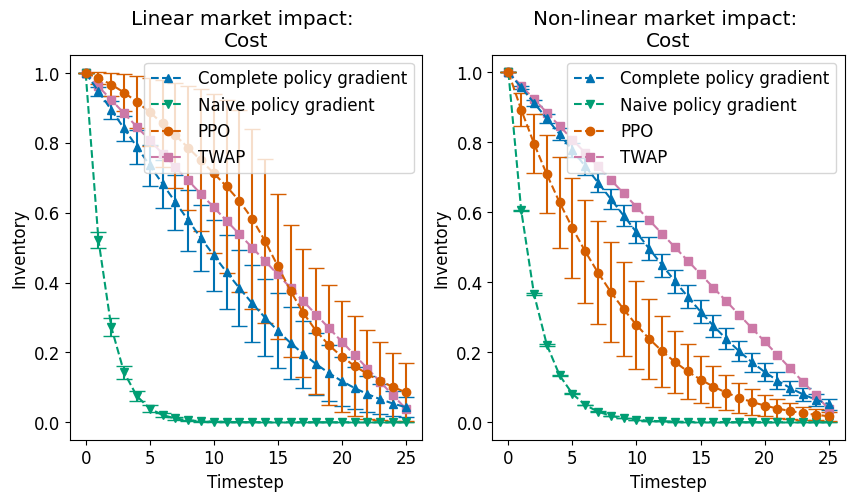

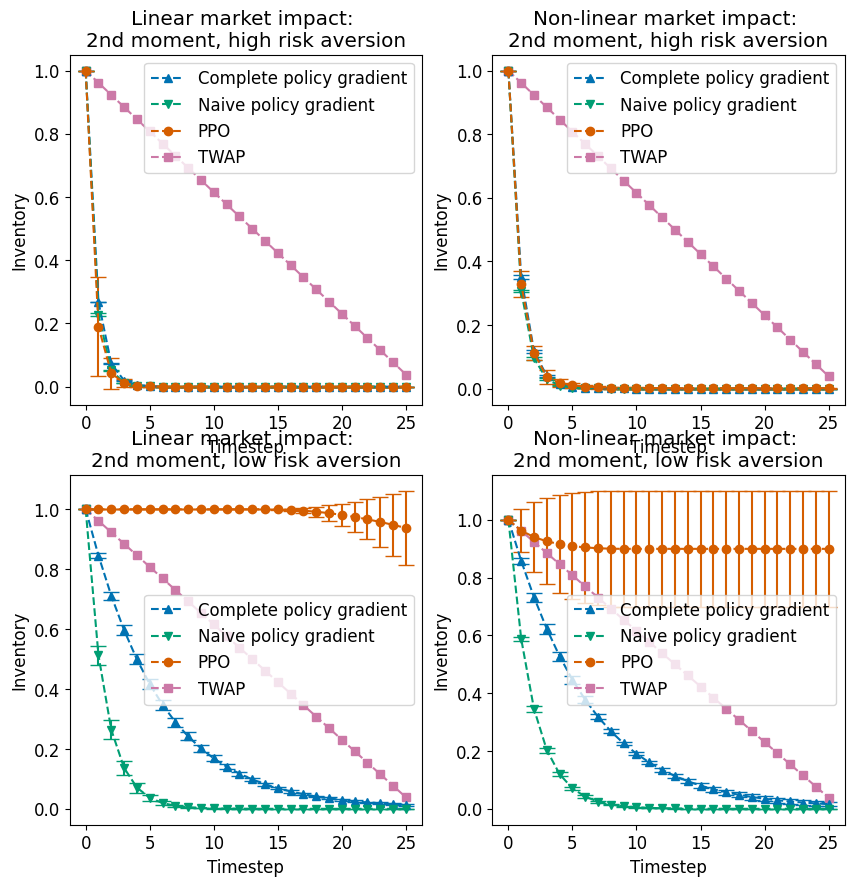

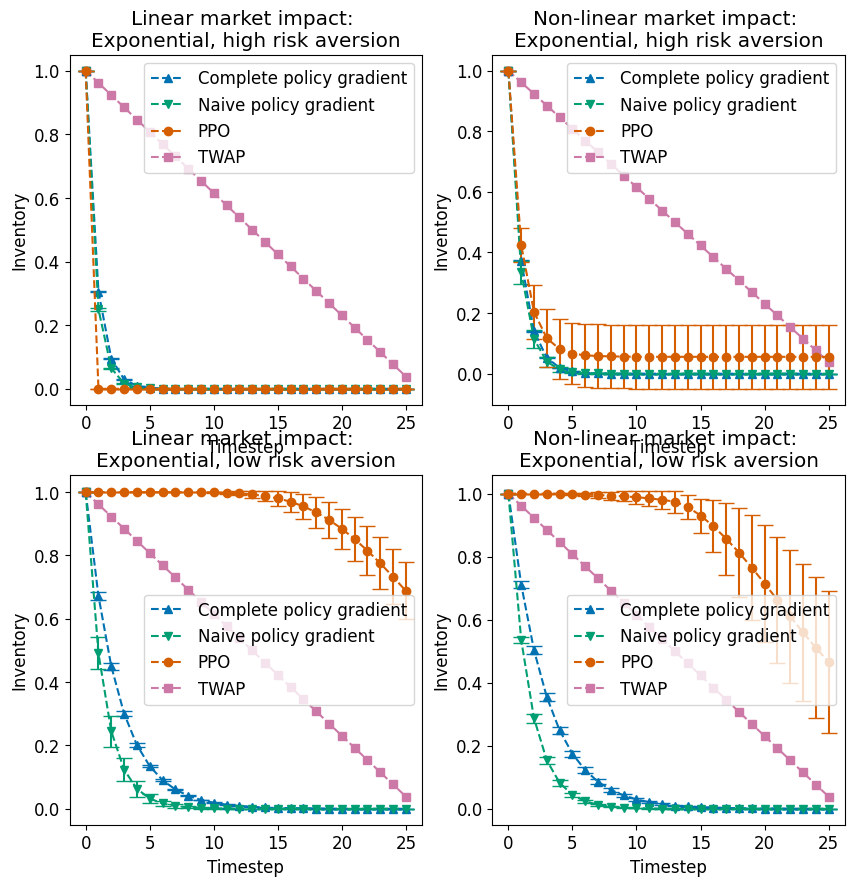

In [8]:
plt.style.use('seaborn-colorblind')
markers = ("^--", "v--", "o--", "s--")
plt.rcParams.update({'font.size': 12})
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
param_vals = (1,2,2)
figs = [plt.subplots(i, 2, figsize=(10,5*i)) for i in param_vals]
axs = [f[1] for f in figs]
titles = ("Linear market impact", "Non-linear market impact")
xs = np.arange(0,results[0]["n"]+1)

for fig_i in range(len(figs)):
    obj_list = [s for s in objectives_list if s.startswith(objective_types[fig_i])]
    for i in range(2):
        for ii in range(param_vals[fig_i]):
            ax = axs[fig_i][i] if param_vals[fig_i] == 1 else axs[fig_i][ii, i] 
            col_idx = 0
            for j in range(len(results)):
                r = results[j]
                if "objective" in r:
                    if r["objective"] == "forsyth":
                        objective_name = "forsyth_low" if r["gamma"] == 300 else "forsyth_high"
                    elif r["objective"] == "exponential":
                        objective_name = "exponential_low" if r["exp_param"] == 0.1 else "exponential_high"
                    else:
                        objective_name = r["objective"]
                if "quantity" in r.keys() and r["objective"] == objective_types[fig_i]:
                    idx = ((1 if r["cost_type"] == "forsyth" else 0), obj_list.index(objective_name))
                    if idx[0] == i and idx[1] == ii:
                        if torch_cols[j]:
                            quantities = torch.mean(r["quantity"], axis=(-1,)).detach().numpy()
                        else:
                            quantities = np.mean(r["quantity"], axis=(-1,))
                        name = names[j].split("_")[0].replace("ppo", "PPO").split(": ")[-1]
                        std_values = np.std(quantities, axis=0)
                        mean_values = np.mean(quantities, axis=0)
                        ax.errorbar(xs, mean_values, yerr=std_values, capsize=6, fmt=markers[col_idx], markersize=6)
                        ax.plot((0,),(1,), markers[col_idx], label=name, color=cols[col_idx], markersize=6)
                        col_idx += 1

            twap_action = -results[0]["alpha0"]/(results[0]["n"] + 1)
            twap_quantity = 1 + np.arange(0,results[0]["n"]+1)*twap_action
            ax.plot(xs, twap_quantity, markers[3], markersize=6)
            ax.plot((0,),(1,),markers[3], label="TWAP", color=cols[3], markersize=6) 
            ax.set_xlabel("Timestep")
            ax.set_ylabel("Inventory")
            ax.legend()
            ax.set_title(titles[i] + ": \n" + objectives[obj_list[ii]])

        tikzplotlib.save('results/order_execution_quantity_{}.tex'.format(objective_types[fig_i]), figure=figs[fig_i][0], encoding='utf-8')
plt.show()

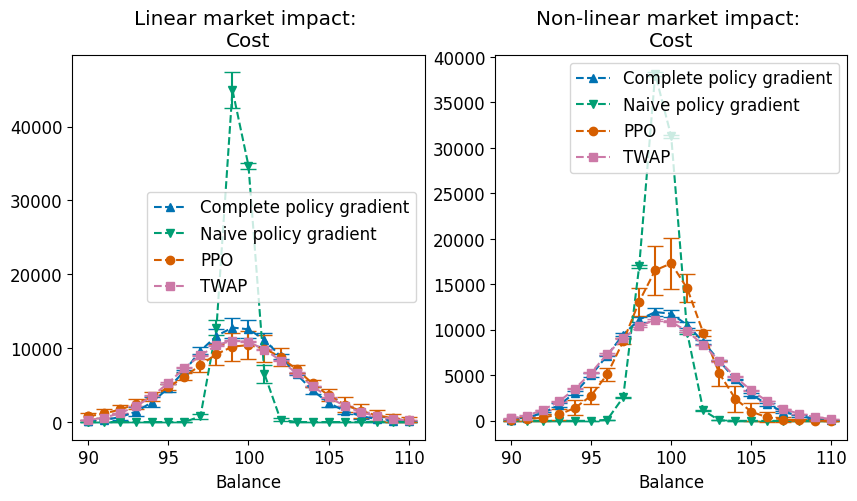

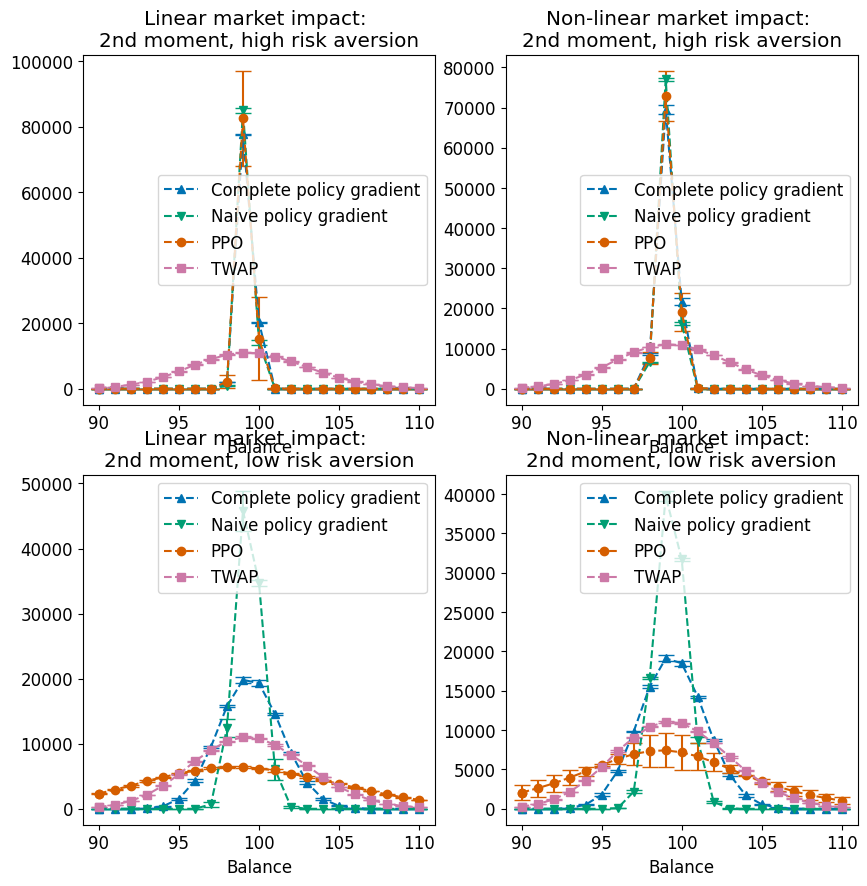

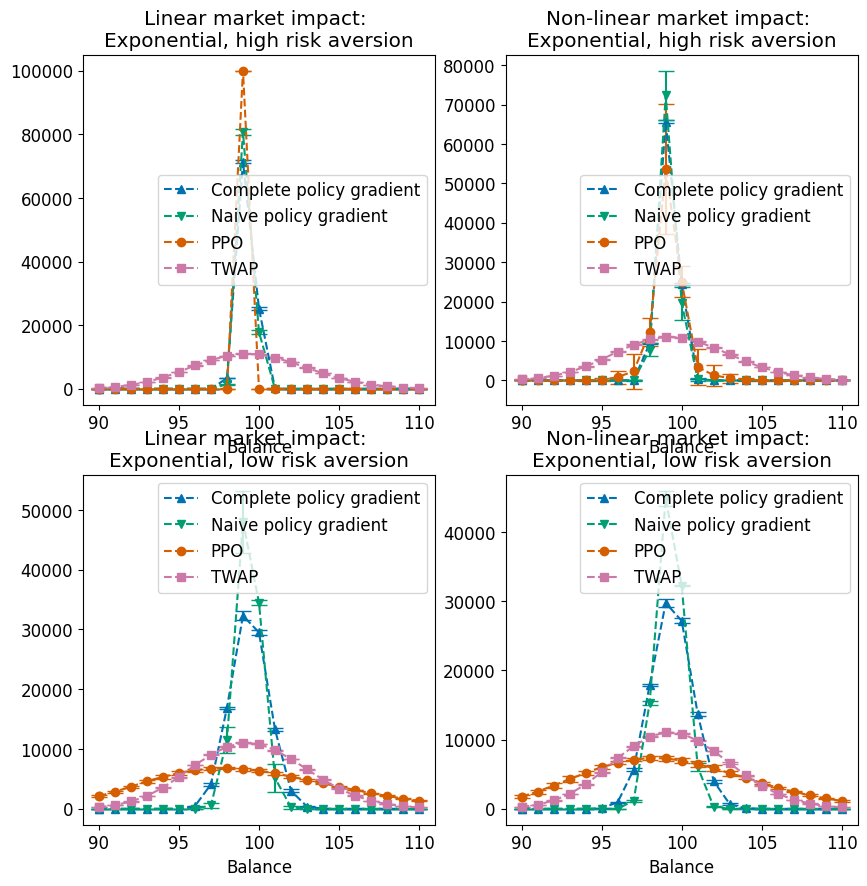

In [9]:
plt.style.use('seaborn-colorblind')
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
param_vals = (1,2,2)
figs = [plt.subplots(i, 2, figsize=(10,5*i)) for i in param_vals]
axs = [f[1] for f in figs]
titles = ("Linear market impact", "Non-linear market impact")
bins = np.arange(89, 111) + 0.5
xs = (bins[1:] + bins[:-1])/2

for fig_i in range(len(figs)):
    obj_list = [s for s in objectives_list if s.startswith(objective_types[fig_i])]
    for i in range(2):
        for ii in range(param_vals[fig_i]):
            ax = axs[fig_i][i] if param_vals[fig_i] == 1 else axs[fig_i][ii, i] 
            col_idx = 0
            for j in range(len(results)):
                r = results[j]
                if "objective" in r:
                    if r["objective"] == "forsyth":
                        objective_name = "forsyth_low" if r["gamma"] == 300 else "forsyth_high"
                    elif r["objective"] == "exponential":
                        objective_name = "exponential_low" if r["exp_param"] == 0.1 else "exponential_high"
                    else:
                        objective_name = r["objective"]
                if "quantity" in r.keys() and r["objective"] == objective_types[fig_i]:
                    idx = ((1 if r["cost_type"] == "forsyth" else 0), obj_list.index(objective_name))
                    if idx[0] == i and idx[1] == ii:
                        name = names[j].split("_")[0].replace("ppo", "PPO").split(": ")[-1]
                        if torch_cols[j]:
                            endvals = r["endvals"].detach().numpy()
                        else:
                            endvals = r["endvals"]
                        freqs = np.stack([np.histogram(endvals[n,:], bins=bins, density=False)[0] for n in range(num_runs)])  
                        std_values = np.std(freqs, axis=0)
                        mean_values = np.mean(freqs, axis=0)
                        ax.errorbar(xs, mean_values, yerr=std_values, capsize=6, fmt=markers[col_idx], markersize=6)
                        ax.plot(xs[0], mean_values[0], markers[col_idx], label=name, color=cols[col_idx], markersize=6)
                        col_idx += 1

            for j in range(len(results)):
                r = results[j]
                if "objective" not in r and names[j] == "TWAP":
                    idx = ((1 if r["cost_type"] == "forsyth" else 0), ii)
                else:
                    idx = ((1 if r["cost_type"] == "forsyth" else 0),-1)
                if idx[0] == i and idx[1] == ii:
                    name = names[j]
                    freqs = np.stack([np.histogram(r["endvals"][n,:], bins=bins, density=False)[0] for n in range(num_runs)])  
                    std_values = np.std(freqs, axis=0)
                    mean_values = np.mean(freqs, axis=0)
                    ax.errorbar(xs, mean_values, yerr=std_values, capsize=6, color=cols[col_idx], fmt=markers[col_idx], markersize=6)
                    ax.plot(xs[0], mean_values[0], markers[col_idx], label=name, color=cols[col_idx], markersize=6)
                    col_idx += 1
            ax.set_xlabel("Balance")
            ax.legend()
            ax.set_title(titles[i] + ": \n" + objectives[obj_list[ii]])

    tikzplotlib.save('results/order_execution_histogram_{}.tex'.format(objective_types[fig_i]), figure=figs[fig_i][0], encoding='utf-8')
plt.show()